# BTC Predictor

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
from ta import *
from IPython.display import HTML
from IPython.core.display import display

import os
import sys
module_path = os.path.abspath(os.path.join('lib/predictor'))
if module_path not in sys.path:
    sys.path.append(module_path)
from stockPredictor import StockPredictor 

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Config


In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

index='Timestamp'
# index='time_period_start'
lookahead = 20
percentIncrease = 1.001
recordsCount = 50000
test_ratio  = 0.95
train_ratio = 0.95
lr = 1e-4
dropout = 0.04
modelName = 'btcBinaryClassificationModel'
dep = 'action'
PATH='data/stock/'

In [4]:
cat_vars = ['TimestampYear', 'TimestampMonth', 'TimestampWeek', 'TimestampDay', 'hour','minute', 'TimestampDayofweek',
'TimestampDayofyear','TimestampIs_month_end', 'TimestampIs_month_start', 'TimestampIs_quarter_end',
'TimestampIs_quarter_start','TimestampIs_year_end', 'TimestampIs_year_start']

contin_vars = ['Open', 'Close','High', 'Low', 'Volume', 'TimestampElapsed',
'volume_adi','volume_obv','volume_obvm','volume_cmf','volume_fi','volume_em','volume_vpt','volume_nvi',
'volatility_atr','volatility_bbh','volatility_bbl','volatility_bbm','volatility_bbhi','volatility_bbli',
'volatility_kcc','volatility_kch','volatility_kcl','volatility_kchi','volatility_kcli','volatility_dch',
'volatility_dcl','volatility_dchi','volatility_dcli','trend_macd','trend_macd_signal','trend_macd_diff',
'trend_ema_fast','trend_ema_slow','trend_adx','trend_vortex_ind_pos',
'trend_vortex_ind_neg','trend_vortex_diff','trend_trix','trend_mass_index','trend_cci','trend_dpo','trend_kst',
'trend_kst_sig','trend_kst_diff','trend_ichimoku_a','trend_ichimoku_b'
,'trend_aroon_up','trend_aroon_down','trend_aroon_ind','momentum_rsi','momentum_mfi','momentum_tsi'
,'momentum_uo','momentum_stoch','momentum_stoch_signal','momentum_wr','momentum_ao','others_dr','others_dlr','others_cr'
,'sma5','sma15','sma30','sma60','sma90'
,'1Open','1High','1Low','1Close','1Volume','2Open','2High','2Low','2Close','2Volume'
,'3Open','3High','3Low','3Close','3Volume','4Open','4High','4Low','4Close','4Volume'
,'5Open','5High','5Low','5Close','5Volume','6Open','6High','6Low','6Close','6Volume'
,'7Open','7High','7Low','7Close','7Volume','8Open','8High','8Low','8Close','8Volume','9Open','9High','9Low'
,'9Close','9Volume','10Open','10High','10Low','10Close','10Volume','11Open','11High','11Low','11Close','11Volume'
,'12Open','12High','12Low','12Close','12Volume','13Open','13High','13Low','13Close','13Volume'
,'14Open','14High','14Low','14Close','14Volume','15Open','15High','15Low','15Close','15Volume'
,'16Open','16High','16Low','16Close','16Volume','17Open','17High','17Low','17Close','17Volume'
,'18Open','18High','18Low','18Close','18Volume','19Open','19High','19Low','19Close','19Volume'
,'20Open','20High','20Low','20Close','20Volume','21Open','21High','21Low','21Close','21Volume'
,'22Open','22High','22Low','22Close','22Volume','23Open','23High','23Low','23Close','23Volume'
,'24Open','24High','24Low','24Close','24Volume','25Open','25High','25Low','25Close','25Volume'
,'26Open','26High','26Low','26Close','26Volume','27Open','27High','27Low','27Close','27Volume'              
]

len(cat_vars),len(contin_vars)

(14, 201)

## Create datasets

In [5]:
table_names = [
#     'coinbaseUSD_1-min_data_2014-12-01_to_2018-06-27',
    'coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11',
#     'bitstampUSD_1-min_data_2012-01-01_to_2018-06-27',
#     'btc-bitstamp-2012-01-01_to_2018-01-08'
#         'BTC_COINBASE_2018-07-25_09-06'
#         'ETH_COINBASE_07-21_08- 24'
]

In [6]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [7]:
for t in tables: display(t.head())

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1417412100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1417412160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1417412220,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
train= tables[0]

In [9]:
# train = train.head(1700000)
p = StockPredictor(train, index)
p.sample_train(recordsCount)

Train size: 50000 Original size: 2016354


## Data Cleaning

In [10]:
p.set_date_as_index_unix()
p.normalize_train('Volume_(BTC)','Open','High','Low','Close', 'Weighted_Price')
# p.set_date_as_index()
# p.normalize_train('volume_traded','price_open','price_high','price_low','price_close', 'price_close')
p.train.head()

,Timestamp,Volume,Open,High,Low,Close,Weighted_Price
1966354,2018-10-07 06:41:00,0.929423,6546.20,6546.21,6546.20,6546.20,6546.207808
1966355,2018-10-07 06:42:00,0.429779,6546.21,6547.32,6546.21,6547.32,6547.193613
1966356,2018-10-07 06:43:00,1.167533,6547.32,6547.32,6547.31,6547.31,6547.319620
1966357,2018-10-07 06:44:00,0.260056,6547.32,6547.32,6547.31,6547.31,6547.316430
1966358,2018-10-07 06:45:00,0.578598,6547.32,6547.32,6547.31,6547.31,6547.310445


## Feature Engineering

In [11]:
# add technical analysis
p.add_ta()
p.clean_train()

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ta/trend.py:170: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ta/trend.py:174: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ta/trend.py:503: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  aroon_up = close.rolling(n).apply(lambda x: float(np.argmax(x) + 1) / n * 100)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ta/trend.py:525: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change

Train size: 50000


In [12]:
p.set_target_hold('Close',lookahead, percentIncrease, 1)

Buy count: 6757 Sell count: 12696 Hold count: 30547


In [13]:
p.add_date_values()
p.trim_ends(100,100)

Trim beginning: 100. Trim end: 100. Train size: 49800


In [14]:
# p.train.to_csv(f'{PATH}btc_historical_parsed.csv', sep=',', encoding='utf-8')
# p.save_to_feather(PATH)
# p.read_from_feather(PATH)
p.train

,Timestamp,Volume,Open,High,Low,Close,Weighted_Price,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,trend_aroon_up,trend_aroon_down,...,23High,23Low,23Close,23Volume,24Open,24High,24Low,24Close,24Volume,25Open,25High,25Low,25Close,25Volume,26Open,26High,26Low,26Close,26Volume,27Open,27High,27Low,27Close,27Volume,28Open,28High,28Low,28Close,28Volume,29Open,29High,29Low,29Close,29Volume,action,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,TimestampElapsed,hour,minute
1966454,2018-10-07 08:21:00,0.699371,6511.24,6511.25,6511.24,6511.24,6511.243800,-0.849417,0.000000,0.446203,-0.218433,-0.001094,3.321211e-01,-2.304407e-07,1001.098902,1.830121,6539.197903,6486.838097,6513.0180,0.0,0.0,6508.612000,6509.553000,6507.671000,0.0,0.0,6535.02,6499.99,0.0,0.0,-5.905000,-7.348756,1.443756,6511.122488,6517.027488,71.904424,1.124173,1.849358,0.725185,-0.017293,29.282754,-10.434263,-13.0180,-4.416814,-4.633382,0.216569,6540.3475,6543.005,4.0,52.0,...,6536.44,6535.01,6535.01,5.566700,6537.21,6537.22,6536.45,6536.45,2.225628,6538.68,6538.69,6537.21,6537.22,1.939635,6540.00,6540.00,6538.68,6538.69,7.430359,6542.01,6542.01,6540.00,6540.01,8.575603,6542.01,6542.01,6542.00,6542.01,0.961438,6542.00,6542.01,6542.00,6542.01,0.149320,1,2018,10,40,7,6,280,False,False,False,False,False,False,1538900460,8,21
1966455,2018-10-07 08:22:00,2.699803,6511.24,6512.00,6511.24,6511.99,6511.938603,1.929384,2.699803,0.535291,-0.208006,1.912318,4.559588e-01,3.109780e-04,1001.098902,1.753684,6535.910492,6487.822508,6511.8665,0.0,0.0,6509.786667,6510.802667,6508.770667,0.0,0.0,6535.01,6499.99,0.0,0.0,-5.398244,-6.958653,1.560410,6511.255952,6516.654195,69.438648,1.949342,0.739474,1.209868,-0.016495,27.881441,-2.204388,-11.8765,-4.082462,-4.623500,0.541038,6539.6125,6542.270,12.0,48.0,...,6535.02,6535.01,6535.01,4.771423,6536.44,6536.44,6535.01,6535.01,5.566700,6537.21,6537.22,6536.45,6536.45,2.225628,6538.68,6538.69,6537.21,6537.22,1.939635,6540.00,6540.00,6538.68,6538.69,7.430359,6542.01,6542.01,6540.00,6540.01,8.575603,6542.01,6542.01,6542.00,6542.01,0.961438,1,2018,10,40,7,6,280,False,False,False,False,False,False,1538900520,8,22
1966456,2018-10-07 08:23:00,0.054032,6512.00,6512.00,6511.99,6511.99,6511.993404,2.574723,0.000000,0.425732,-0.206376,-0.484004,4.586961e-01,3.109780e-04,1001.098902,1.629135,6532.157893,6489.273107,6510.7155,0.0,0.0,6510.783667,6511.495667,6510.071667,0.0,0.0,6535.00,6499.99,0.0,0.0,-4.939692,-6.554861,1.615169,6511.368882,6516.308575,67.148999,1.460526,0.538158,0.922368,-0.015633,26.553233,6.095529,-10.7155,-3.763099,-4.542668,0.779569,6539.2325,6541.890,8.0,44.0,...,6535.02,6535.01,6535.02,0.772771,6535.01,6535.02,6535.01,6535.01,4.771423,6536.44,6536.44,6535.01,6535.01,5.566700,6537.21,6537.22,6536.45,6536.45,2.225628,6538.68,6538.69,6537.21,6537.22,1.939635,6540.00,6540.00,6538.68,6538.69,7.430359,6542.01,6542.01,6540.00,6540.01,8.575603,1,2018,10,40,7,6,280,False,False,False,False,False,False,1538900580,8,23
1966457,2018-10-07 08:24:00,0.693694,6511.99,6512.00,6511.99,6512.00,6511.996260,0.639661,0.693694,0.481495,-0.202186,-0.020061,4.586961e-01,1.065256e-06,1001.098902,1.513482,6527.742409,6491.388591,6509.5655,0.0,0.0,6511.179667,6511.891667,6510.467667,0.0,0.0,6534.98,6499.99,0.0,0.0,-4.523337,-6.148556,1.625219,6511.465

## Split validation and test sets

In [15]:
p.split_test_train(test_ratio)

Train size: 47310 Test size: 2490


In [16]:
# p.train.head()

In [17]:
p.train.tail(50).T.head(100)

Timestamp,2018-11-09 04:01:00,2018-11-09 04:02:00,2018-11-09 04:03:00,2018-11-09 04:04:00,2018-11-09 04:05:00,2018-11-09 04:06:00,2018-11-09 04:07:00,2018-11-09 04:08:00,2018-11-09 04:09:00,2018-11-09 04:10:00,2018-11-09 04:11:00,2018-11-09 04:12:00,2018-11-09 04:13:00,2018-11-09 04:14:00,2018-11-09 04:15:00,2018-11-09 04:16:00,2018-11-09 04:17:00,2018-11-09 04:18:00,2018-11-09 04:19:00,2018-11-09 04:20:00,2018-11-09 04:21:00,2018-11-09 04:22:00,2018-11-09 04:23:00,2018-11-09 04:24:00,2018-11-09 04:25:00,2018-11-09 04:26:00,2018-11-09 04:27:00,2018-11-09 04:28:00,2018-11-09 04:29:00,2018-11-09 04:30:00,2018-11-09 04:31:00,2018-11-09 04:32:00,2018-11-09 04:33:00,2018-11-09 04:34:00,2018-11-09 04:35:00,2018-11-09 04:36:00,2018-11-09 04:37:00,2018-11-09 04:38:00,2018-11-09 04:39:00,2018-11-09 04:40:00,2018-11-09 04:41:00,2018-11-09 04:42:00,2018-11-09 04:43:00,2018-11-09 04:44:00,2018-11-09 04:45:00,2018-11-09 04:46:00,2018-11-09 04:47:00,2018-11-09 04:48:00,2018-11-09 04:49:00,2018-11-09 04:50:00
Volume,0.762828,11.1547,4.45316,1.83817,35.0841,0.867799,1.12694,9.06986,7.55637,4.32151,1.04453,1.32877,1.68242,0.633438,3.65955,1.15726,3.68985,1.06802,0.333413,2.62235,1.63933,1.53429,0.93283,0.249222,0.345528,1.3885,2.96873,2.6628,0.977216,0.77534,1.03495,24.819,1.31107,0.657166,3.01855,2.73437,2.92233,2.10743,1.02072,25.0455,1.64635,12.8661,4.60189,0.704686,0.460233,0.686331,0.668691,0.426592,2.10351,1.03286
Open,6399.76,6399.76,6399.99,6400,6404.97,6404.99,6404.99,6404.99,6404.53,6401.03,6403.33,6402.9,6401.74,6402.2,6404.03,6404.1,6404.9,6404,6404,6403.99,6401.79,6401.01,6401,6401.78,6401.78,6401.78,6401.79,6401.79,6401.79,6401.79,6401.79,6401.79,6401.8,6401.8,6401.8,6401.81,6403.99,6403.89,6403.88,6403.88,6403.89,6403.89,6405,6404.99,6405,6404.99,6404.99,6404.99,6404.99,6404.51
High,6399.77,6399.99,6400,6404.98,6405.35,6405,6405,6405,6404.53,6403.91,6403.34,6402.9,6402.2,6404,6405,6404.99,6404.91,6404,6404,6404,6401.8,6401.01,6401.79,6401.79,6401.79,6401.8,6401.8,6401.8,6401.8,6401.8,6401.8,6401.8,6401.81,6401.81,6401.81,6403.99,6403.99,6403.89,6403.89,6403.89,6403.89,6405,6405,6405,6405,6405,6405,6405,6405,6404.51
Low,6399.76,6399.76,6399.98,6399.99,6404.97,6404.99,6404.99,6404.52,6401,6401.02,6402.89,6401.69,6401.2,6402.19,6404.03,6404.09,6403.99,6403.99,6403.99,6401.78,6401,6401,6401,6401.78,6401.78,6401.78,6401.79,6401.79,6401.79,6401.79,6401.79,6401.79,6401.8,6401.8,6401.8,6401.8,6403.88,6403.88,6403.88,6403.29,6403.88,6403.88,6404.99,6404.99,6404.99,6404.99,6404.99,6404.99,6404.5,6404.5
Close,6399.77,6399.98,6399.99,6404.98,6404.99,6405,6404.99,6404.53,6401.02,6403.34,6402.9,6401.75,6402.2,6404,6404.23,6404.91,6404,6404,6403.99,6401.8,6401.01,6401,6401.78,6401.78,6401.79,6401.8,6401.8,6401.8,6401.8,6401.8,6401.8,6401.8,6401.8,6401.81,6401.81,6403.98,6403.89,6403.89,6403.88,6403.89,6403.88,6404.99,6404.99,6405,6404.99,6405,6405,6405,6404.51,6404.51
Weighted_Price,6399.77,6399.82,6399.99,6401.88,6405.29,6405,6404.99,6404.96,6402.07,6402.48,6403.16,6401.94,6401.79,6403.75,6404.73,6404.82,6404.45,6403.99,6404,6403.16,6401.54,6401,6401.75,6401.78,6401.78,6401.79,6401.8,6401.79,6401.79,6401.8,6401.79,6401.8,6401.8,6401.81,6401.8,6403.45,6403.96,6403.89,6403.88,6403.87,6403.89,6404.13,6405,6404.99,6405,6404.99,6405,6405,6404.71,6404.5
volume_adi,-1.75124,10.9476,10.1847,1.83817,-29.5529,-30.5233,-0.259146,-9.81889,-16.1627,-4.85391,1.61873,-2.19509,0.485431,2.31586,-1.51702,-1.19893,-2.65811,-2.54162,0.734603,-2.90851,-4.17345,-3.13264,-0.625078,0.659991,0.0963055,1.73403,4.35723,5.63153,3.64001,1.75256,1.81029,25.854,23.508,-0.653905,3.67571,5.72794,0.3184,-0.283569,1.08671,24.0248,23.3992,10.99,8.03449,-3.89721,0.244453,0.226098,1.35502,1.09528,-1.59277,-0.986505
volume_obv,0.762828,11.1547,4.45316,1.83817,35.0841,0.867799,-1.12694,-9.06986,-7.55637,4.32151,-1.04453,-1.32877,1.68242,0.633438,3.65955,1.15726,-3.68985,0,-0.333413,-2.62235,-1.63933,-1.53429,0.93283,0,0.345528,1.3885,0,0,0,0,0,0,0,0.657166,0,2.73437,-2.92233,0,-1.0

## Create features

In [18]:
p.train = p.apply_variable_types(p.train, cat_vars, contin_vars, dep)
p.test = p.apply_variable_types(p.test, cat_vars, contin_vars, dep)
apply_cats(p.test, p.train)

In [19]:
df, y, nas, mapper = proc_df(p.train, dep, do_scale=True)

In [20]:
df_test, _, nas, mapper = proc_df(p.test, dep, do_scale=True, mapper=mapper, na_dict=nas)
nas={}
# p.train.head(30).T.head(70)

In [21]:
df.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,Volume,TimestampElapsed,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_vortex_ind_pos,...,18Open,18High,18Low,18Close,18Volume,19Open,19High,19Low,19Close,19Volume,20Open,20High,20Low,20Close,20Volume,21Open,21High,21Low,21Close,21Volume,22Open,22High,22Low,22Close,22Volume,23Open,23High,23Low,23Close,23Volume,24Open,24High,24Low,24Close,24Volume,25Open,25High,25Low,25Close,25Volume,26Open,26High,26Low,26Close,26Volume,27Open,27High,27Low,27Close,27Volume
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-07 08:21:00,1,1,1,7,9,22,7,1,1,1,1,1,1,1,1.235224,1.235221,1.230952,1.239517,-0.235673,-1.732007,-0.095658,0.007108,0.101823,-0.854348,-0.001687,0.475130,0.003198,-1.851233,1.180255,1.464481,1.035125,1.254363,-0.249764,-0.26776,1.210114,1.210290,1.209198,-0.037092,-0.029451,1.434048,1.15562,-0.555783,-0.483461,-1.944960,-2.566728,1.600465,1.235164,1.294958,3.562889,0.080624,...,1.469582,1.465347,1.473791,1.469591,-0.242947,1.469515,1.465285,1.473733,1.469630,-0.262181,1.469453,1.465228,1.473666,1.469573,-0.154199,1.469386,1.465166,1.473608,1.469511,-0.230045,1.469333,1.465109,1.473546,1.469342,0.074428,1.483421,1.479089,1.473479,1.46929,0.134980,1.490969,1.486749,1.487661,1.483469,-0.119426,1.505446,1.501224,1.495118,1.491022,-0.141204,1.518439,1.514113,1.509584,1.505494,0.276877,1.538249,1.533932,1.522566,1.518482,0.364069
2018-10-07 08:22:00,1,1,1,7,9,23,7,1,1,1,1,1,1,1,1.235224,1.242643,1.238375,1.239517,-0.083140,-1.732007,0.081275,0.207582,0.118563,-0.827822,0.001447,0.660457,0.005610,-1.851233,1.121424,1.431993,1.044823,1.242957,-0.249764,-0.26776,1.221745,1.222664,1.220075,-0.037092,-0.029451,1.433946,1.15562,-0.555783,-0.483461,-1.777706,-2.430239,1.729844,1.236484,1.291259,3.286386,0.971562,...,1.469485,1.465246,1.473694,1.469494,-0.261673,1.469515,1.465285,1.473733,1.469529,-0.242914,1.469453,1.465228,1.473666,1.469573,-0.262182,1.469386,1.465166,1.473608,1.469511,-0.154199,1.469333,1.465109,1.473546,1.469444,-0.230051,1.469275,1.465042,1.473479,1.46929,0.074423,1.483353,1.479030,1.473420,1.469222,0.134981,1.490905,1.486685,1.487607,1.483406,-0.119427,1.505386,1.501154,1.495049,1.490958,-0.141215,1.518372,1.514052,1.509518,1.505429,0.276864


In [22]:
df_test.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,Volume,TimestampElapsed,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_vortex_ind_pos,...,18Open,18High,18Low,18Close,18Volume,19Open,19High,19Low,19Close,19Volume,20Open,20High,20Low,20Close,20Volume,21Open,21High,21Low,21Close,21Volume,22Open,22High,22Low,22Close,22Volume,23Open,23High,23Low,23Close,23Volume,24Open,24High,24Low,24Close,24Volume,25Open,25High,25Low,25Close,25Volume,26Open,26High,26Low,26Close,26Volume,27Open,27High,27Low,27Close,27Volume
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-11-09 04:51:00,1,2,6,9,5,52,5,34,1,1,1,1,1,1,0.179016,0.179015,0.174566,0.183776,-0.216563,1.732007,-0.036298,-0.063434,0.219848,1.404588,-0.001666,-0.023676,0.003189,1.3308,-0.228319,0.151398,0.195148,0.173994,-0.249764,-0.26776,0.182586,0.174854,0.190206,-0.037092,-0.029451,0.148952,0.188255,-0.555783,-0.483461,0.214577,0.238151,-0.033855,0.178682,0.172430,-0.014743,0.233857,...,0.151846,0.147388,0.156623,0.151847,-0.189089,0.151712,0.147255,0.156499,0.151814,1.600965,0.15168,0.147227,0.156461,0.151787,-0.210081,0.151642,0.147195,0.156434,0.151754,-0.229849,0.15162,0.147167,0.156401,0.151717,-0.214483,0.151592,0.14713,0.156364,0.151694,-0.086139,0.151555,0.147103,0.156336,0.151657,-0.062842,0.151421,0.14707,0.156212,0.151625,-0.183170,0.151393,0.146936,0.156174,0.151495,-0.262599,0.15136,0.146908,0.156141,0.151361,-0.269946
2018-11-09 04:52:00,1,2,6,9,5,53,5,34,1,1,1,1,1,1,0.179016,0.179112,0.174566,0.183776,-0.180618,1.732163,-0.011558,0.112654,0.004806,1.108275,-0.001685,-0.023650,0.003206,1.3308,-0.228319,0.150582,0.198630,0.175333,-0.249764,-0.26776,0.182470,0.173640,0.191186,-0.037092,-0.029451,0.148952,0.188255,-0.555783,-0.483461,0.200345,0.233047,-0.065501,0.178759,0.172938,-0.014743,0.233857,...,0.151846,0.147388,0.156623,0.151948,-0.238879,0.151809,0.147356,0.156595,0.151814,-0.189054,0.15168,0.147227,0.156461,0.151787,1.600964,0.151642,0.147195,0.156434,0.151754,-0.210081,0.15162,0.147167,0.156401,0.151717,-0.229855,0.151592,0.14713,0.156364,0.151694,-0.214488,0.151555,0.147103,0.156336,0.151657,-0.086138,0.151522,0.14707,0.156313,0.151625,-0.062843,0.151393,0.147033,0.156174,0.151592,-0.183181,0.15136,0.146908,0.156141,0.151463,-0.262612


Rake the last x% of rows as our validation set.

In [23]:
train_size = p.get_train_size(train_ratio)
val_idx = p.get_validation_indexes(train_size, df)

Train size: 44944 percent_split: 0.95
Validation Index size: 2366


## DL

We can create a ModelData object directly from our data frame. Is_Reg is set to False to turn this into a classification problem (from a regression).

In [24]:
# y = y.reshape(len(y),1)
md = ColumnarModelData.from_data_frame(PATH, val_idx, df,y.astype('int'), cat_flds=cat_vars, bs=128,
                                      is_reg=False,is_multi=False,test_df=df_test)

Some categorical variables have a lot more levels than others.

In [25]:
cat_sz = [(c, len(p.train[c].cat.categories)+1) for c in cat_vars]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
cont_size = len(df.columns)-len(cat_vars)

In [26]:
activations=[500,100]
dropout_later_layers= [0.01,0.1] 
m = md.get_learner(emb_szs, cont_size,dropout, 3, activations,dropout_later_layers,None,True)

from torch.nn import functional as F
m.crit = F.cross_entropy

In [27]:
# def accuracy(preds, targs, thresh=0.5):
#     return ((preds>thresh).float()==targs).float().mean()

def accuracy(preds, targs):
    preds = torch.max(preds, dim=1)[1]
    return (preds==targs).float().mean()

 71%|███████▏  | 251/352 [00:04<00:01, 93.98it/s, loss=1.06] 


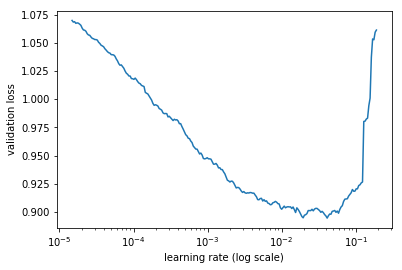

In [28]:
m.lr_find()
m.sched.plot(10)

In [29]:
m.fit(lr, 2, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                     
    0      0.878477   0.897204   0.585799  
    1      0.856518   0.88996    0.587489                     



[array([0.88996]), 0.5874894337944327]

In [30]:
m.fit(lr, 5, cycle_len=1, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                     
    0      0.840001   0.884229   0.586221  
    1      0.83329    0.885474   0.587067                     
    2      0.830231   0.885244   0.58918                      
    3      0.82417    0.887649   0.590025                     
    4      0.813915   0.889037   0.58918                     



[array([0.88904]), 0.5891800508696652]

In [31]:
m.fit(lr, 3, cycle_len=4, cycle_mult=2 , metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                     
    0      0.831698   0.890478   0.584108  
    1      0.809467   0.8933     0.583263                     
    2      0.817063   0.894214   0.583263                     
    3      0.801145   0.896249   0.587489                     
    4      0.809997   0.896219   0.584954                     
    5      0.797975   0.901963   0.590025                     
    6      0.803899   0.905612   0.587067                    
    7      0.783599   0.899904   0.594252                     
    8      0.78462    0.902835   0.592561                    
    9      0.798923   0.902547   0.592561                     
    10     0.796821   0.903021   0.592984                     
    11     0.803181   0.903627   0.593407                     
    12     0.790781   0.911497   0.586644                     
    13     0.784955   0.90674    0.599324                     
    14     0.786144   0.908349   0.594252                     
    15     0.

[array([0.92078]), 0.5879120880632409]

In [32]:
m.save(modelName)

In [33]:
m.load(modelName)

## Validation

In [34]:
(x,yl)=m.predict_with_targs()
# x

In [35]:
val = p.train.iloc[val_idx]
val[[dep]]
valpred = pd.DataFrame({
    'Close':val.Close,
    'index':val.index,
    'action':val.action,
    'predicted': np.argmax(x,axis=1),
})[['Close','index', 'action','predicted']]
# valpred


sell_count = str(len(valpred[valpred.predicted == 0]))
hold_count = str(len(valpred[valpred.predicted == 1]))
buy_count = str(len(valpred[valpred.predicted == 2]))
print('Buy count: ' + buy_count + ' Sell count: ' + sell_count + ' Hold count: ' + hold_count)
valpred

Buy count: 45 Sell count: 386 Hold count: 1935


,Close,index,action,predicted
Timestamp,,,,
2018-11-07 13:25:00,6506.459961,2018-11-07 13:25:00,1,1
2018-11-07 13:26:00,6506.470215,2018-11-07 13:26:00,1,1
2018-11-07 13:27:00,6506.459961,2018-11-07 13:27:00,1,1
2018-11-07 13:28:00,6504.359863,2018-11-07 13:28:00,1,1
2018-11-07 13:29:00,6504.359863,2018-11-07 13:29:00,1,1
2018-11-07 13:30:00,6504.359863,2018-11-07 13:30:00,2,1
2018-11-07 13:31:00,6504.359863,2018-11-07 13:31:00,2,1
2018-11-07 13:32:00,6504.350098,2018-11-07 13:32:00,2,1
2018-11-07 13:33:00,6504.350098,2018-11-07 13:33:00,2,1


Calculate the percent accuracy on the validation set

In [36]:
p.calculate_accuracy_hold(valpred)

{'F1Score': 0.398,
 'totalAccuracy': 0.588,
 'buyAccuracy': 0.095,
 'sellAccuracy': 0.241,
 'hold_accuracy': 0.858,
 'totalSellActions': 751,
 'totalHoldActions': 1384,
 'totalBuyActions': 231,
 'successfulBuyPredictions': 22}

In [37]:
p.calculate_net_profit_hold(valpred, 15000, 0)
p.result

{'startClose': 6506.46,
 'endClose': 6404.51,
 'startAmount': 15000,
 'endAmount': 15013.4864950298,
 'buyAndHoldPercentIncrease': -1.567,
 'percentIncrease': 0.09,
 'percentDifference': 1.657,
 'totalTrades': 12}

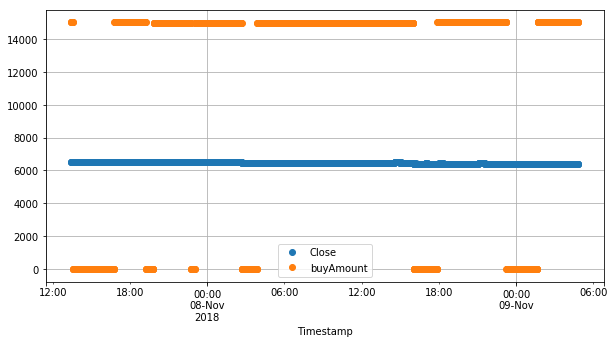

In [38]:
p.plot_profit(p.net_profit_df)

In [39]:
p.net_profit_df

,Timestamp,Close,index,action,predicted,buyAmount,sellAmount
0,2018-11-07 13:25:00,6506.459961,2018-11-07 13:25:00,1,1,15000.000000,0.000000
1,2018-11-07 13:26:00,6506.470215,2018-11-07 13:26:00,1,1,15000.000000,0.000000
2,2018-11-07 13:27:00,6506.459961,2018-11-07 13:27:00,1,1,15000.000000,0.000000
3,2018-11-07 13:28:00,6504.359863,2018-11-07 13:28:00,1,1,15000.000000,0.000000
4,2018-11-07 13:29:00,6504.359863,2018-11-07 13:29:00,1,1,15000.000000,0.000000
5,2018-11-07 13:30:00,6504.359863,2018-11-07 13:30:00,2,1,15000.000000,0.000000
6,2018-11-07 13:31:00,6504.359863,2018-11-07 13:31:00,2,1,15000.000000,0.000000
7,2018-11-07 13:32:00,6504.350098,2018-11-07 13:32:00,2,1,15000.000000,0.000000
8,2018-11-07 13:33:00,6504.350098,2018-11-07 13:33:00,2,1,15000.000000,0.000000
9,2018-11-07 13:34:00,6507.500000,2018-11-07 13:34:00,1,2,0.000000,2.305033


## Test

In [40]:
np.argmax(m.predict(True), axis =1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [41]:
testPred = pd.DataFrame({
    'index':p.test.index,
    'Close':p.test.Close,
    'action':p.test.action, 
    'predicted':np.argmax(m.predict(True), axis =1)
})[['index','Close','action', 'predicted']]
testPred.head(10)

,index,Close,action,predicted
Timestamp,,,,
2018-11-09 04:51:00,2018-11-09 04:51:00,6404.500000,1,1
2018-11-09 04:52:00,2018-11-09 04:52:00,6404.509766,0,1
2018-11-09 04:53:00,2018-11-09 04:53:00,6404.509766,0,1
2018-11-09 04:54:00,2018-11-09 04:54:00,6404.509766,0,1
2018-11-09 04:55:00,2018-11-09 04:55:00,6403.669922,1,1
2018-11-09 04:56:00,2018-11-09 04:56:00,6402.430176,1,1
2018-11-09 04:57:00,2018-11-09 04:57:00,6402.419922,1,1
2018-11-09 04:58:00,2018-11-09 04:58:00,6402.430176,1,1
2018-11-09 04:59:00,2018-11-09 04:59:00,6402.430176,1,1


In [42]:
p.calculate_accuracy_hold(testPred)

{'F1Score': 0.452,
 'totalAccuracy': 0.599,
 'buyAccuracy': 0.27,
 'sellAccuracy': 0.147,
 'hold_accuracy': 0.938,
 'totalSellActions': 918,
 'totalHoldActions': 1394,
 'totalBuyActions': 178,
 'successfulBuyPredictions': 48}

In [43]:
p.calculate_net_profit_hold(testPred, 15000, 0)
p.result

{'startClose': 6404.5,
 'endClose': 6360.82,
 'startAmount': 15000,
 'endAmount': 14957.383584943951,
 'buyAndHoldPercentIncrease': -0.682,
 'percentIncrease': -0.284,
 'percentDifference': 0.398,
 'totalTrades': 8}

In [44]:
p.net_profit_df

,index,Close,action,predicted,buyAmount,sellAmount
Timestamp,,,,,,
2018-11-09 04:51:00,2018-11-09 04:51:00,6404.500000,1,1,15000.000000,0.0
2018-11-09 04:52:00,2018-11-09 04:52:00,6404.509766,0,1,15000.000000,0.0
2018-11-09 04:53:00,2018-11-09 04:53:00,6404.509766,0,1,15000.000000,0.0
2018-11-09 04:54:00,2018-11-09 04:54:00,6404.509766,0,1,15000.000000,0.0
2018-11-09 04:55:00,2018-11-09 04:55:00,6403.669922,1,1,15000.000000,0.0
2018-11-09 04:56:00,2018-11-09 04:56:00,6402.430176,1,1,15000.000000,0.0
2018-11-09 04:57:00,2018-11-09 04:57:00,6402.419922,1,1,15000.000000,0.0
2018-11-09 04:58:00,2018-11-09 04:58:00,6402.430176,1,1,15000.000000,0.0
2018-11-09 04:59:00,2018-11-09 04:59:00,6402.430176,1,1,15000.000000,0.0


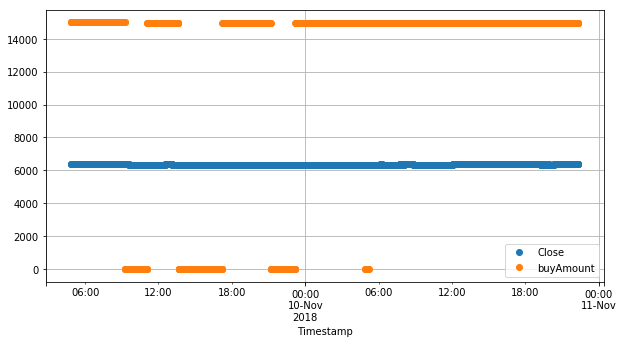

In [45]:
p.plot_profit(p.net_profit_df)

Confusion matrix, without normalization
[[ 135  768   15]
 [  68 1308   18]
 [   2  128   48]]


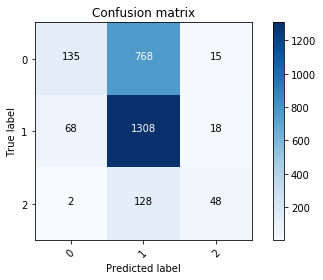

In [46]:
p.confusion_matrix(testPred.action, testPred.predicted, ['0', '1', '2'], [0, 1, 2])

## RF

In [47]:
from sklearn.ensemble import RandomForestClassifier
mrf = RandomForestClassifier(n_estimators=150, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
mrf.fit(df.values, y);
mrf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.99, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [48]:
mrf.score(df_test.values,p.test[dep])

0.5795180722891566

In [49]:
preds = mrf.predict(df_test.values)
testPred.predicted = preds

Confusion matrix, without normalization
[[ 167  734   17]
 [ 132 1230   32]
 [  23  109   46]]


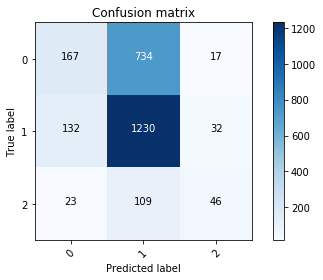

In [50]:
p.confusion_matrix(testPred.action, testPred.predicted, ['0', '1', '2'], [0, 1, 2])

In [51]:
p.calculate_accuracy_hold(testPred)

{'F1Score': 0.441,
 'totalAccuracy': 0.58,
 'buyAccuracy': 0.258,
 'sellAccuracy': 0.182,
 'hold_accuracy': 0.882,
 'totalSellActions': 918,
 'totalHoldActions': 1394,
 'totalBuyActions': 178,
 'successfulBuyPredictions': 46}

In [52]:
p.calculate_net_profit_hold(testPred, 15000, 0)
p.result

{'startClose': 6404.5,
 'endClose': 6360.82,
 'startAmount': 15000,
 'endAmount': 15048.392744094068,
 'buyAndHoldPercentIncrease': -0.682,
 'percentIncrease': 0.323,
 'percentDifference': 1.005,
 'totalTrades': 22}

## AdaBoost

In [53]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(random_state=1, learning_rate=0.5)
ada.fit(df.values, y)
ada

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=50, random_state=1)

In [54]:
ada.score(df_test.values,p.test[dep])

0.5783132530120482

In [55]:
preds = ada.predict(df_test.values)
testPred.predicted = preds

Confusion matrix, without normalization
[[  58  859    1]
 [  16 1376    2]
 [   2  170    6]]


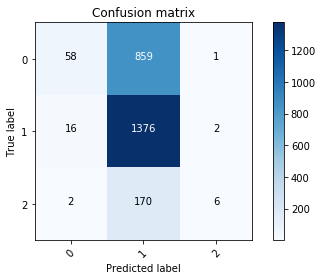

In [56]:
p.confusion_matrix(testPred.action, preds, ['0', '1', '2'], [0, 1, 2])

In [57]:
p.calculate_accuracy_hold(testPred)

{'F1Score': 0.361,
 'totalAccuracy': 0.578,
 'buyAccuracy': 0.034,
 'sellAccuracy': 0.063,
 'hold_accuracy': 0.987,
 'totalSellActions': 918,
 'totalHoldActions': 1394,
 'totalBuyActions': 178,
 'successfulBuyPredictions': 6}

In [58]:
p.calculate_net_profit_hold(testPred, 15000, 0)
p.result

{'startClose': 6404.5,
 'endClose': 6360.82,
 'startAmount': 15000,
 'endAmount': 14917.929661054422,
 'buyAndHoldPercentIncrease': -0.682,
 'percentIncrease': -0.547,
 'percentDifference': 0.135,
 'totalTrades': 6}

## Playground

In [59]:
# list(p.train.columns.values)
m.crit

<function torch.nn.functional.cross_entropy(input, target, weight=None, size_average=True, ignore_index=-100, reduce=True)>

In [60]:
# val_idx
# y